## While Deploying Model we must ourselves 3 questions
1. __What is my most ideal machine learning model deployment scenario ?__
2. __Where is my model going to go (cloud or on device)?__
3. __How is my model going to functions ?__ <br>
<br>
#### For Our FoodVision Mini model <br>
1. __What is the most ideal machine learning model deployment scenario ?__ <br>
> - Performs well: 95%+ accuracy
> - Fast: as close as real time (30FPS+ or 30ms latency)

2. __Where is my model going to go ?__ <br>
> 

3. __How is my model going to function ?__ <br>
>

In [1]:
import torch
import torchvision

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] couldn't find torchinfo... installing...")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    print(f"[INFO] could't find going_modular scripts... downloading...")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device 

'mps'

In [6]:
# removing the current data folder in going_modular as it contains 10% data
import os
os.system('rm -rf going_modular/data')

0

In [7]:
import os
import requests
import zipfile

def download_data(source: str, destination: str):
    """
    Downloads a zip file from the specified source URL and extracts it to the specified destination directory.

    Parameters:
    source (str): URL of the zip file to be downloaded.
    destination (str): Directory where the zip file should be extracted.
    """
    # Check if the destination directory already exists
    if not os.path.exists(destination):
        os.makedirs(destination)

    # Download the file
    print(f"[INFO] Downloading data from {source}...")
    response = requests.get(source)
    zip_path = os.path.join(destination, "data.zip")

    # Save the zip file
    with open(zip_path, "wb") as f:
        f.write(response.content)
    
    # Extract the zip file
    print(f"[INFO] Extracting data to {destination}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(destination)
    
    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"[INFO] Data downloaded and extracted to {destination}.")
    

download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
              destination="going_modular/data")

[INFO] Downloading data from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Extracting data to going_modular/data...
[INFO] Data downloaded and extracted to going_modular/data.


In [8]:
# setting up training and test paths
from pathlib import Path

data_path = Path("going_modular/data")

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/train'), PosixPath('going_modular/data/test'))

### What we are gonna do is make 2 models 1. Efficientnet_B2 and 2. ViT <br> Compare the results and deploy which best suits our expectation


## Creating Efficientnet_B2 

In [9]:
from going_modular import data_setup
from torchvision import transforms

# creating auto_transform_effnetbs
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transform = weights.transforms()


train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir, 
                                                                                                 transform=effnetb2_transform,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [10]:
# creating model
from torch import nn

effnetb2 = torchvision.models.efficientnet_b2(weights=weights).to(device)

# freezing all the layers of the model
for parameter in effnetb2.parameters():
    parameter.requires_grad=False
    
# creating the last layer
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=len(class_names))
).to(device)

In [11]:
# creaing a function to create the effnetb2 model
def create_effnetb2_model():
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    
    # create transform
    effnetb2_transform = effnetb2_weights.transforms()
    
    # creating model
    effnetb2 = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # freeze all the layers
    for param in effnetb2.parameters():
        param.requires_grad = False
        
    # create the last layer
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=len(class_names))
    )
    
    return effnetb2, effnetb2_transform

In [12]:
effnetb2, effnetb2_transform = create_effnetb2_model()

# printing summary
summary(effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [13]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transform,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

In [14]:
# training the model
from going_modular import engine

# setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2, 
                                test_dataloader=test_dataloader_effnetb2,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                epochs=10)

Epoch:0	Train_Loss:0.9465	Train_Acc:60.6250	Test_Loss:0.7323	Test_Acc:85.8523
Epoch:1	Train_Loss:0.7166	Train_Acc:77.7083	Test_Loss:0.5910	Test_Acc:93.5227
Epoch:2	Train_Loss:0.5579	Train_Acc:89.7917	Test_Loss:0.5026	Test_Acc:93.5227
Epoch:3	Train_Loss:0.4961	Train_Acc:90.4167	Test_Loss:0.4286	Test_Acc:94.0909
Epoch:4	Train_Loss:0.4111	Train_Acc:90.8333	Test_Loss:0.3931	Test_Acc:94.4318
Epoch:5	Train_Loss:0.4229	Train_Acc:87.0833	Test_Loss:0.3613	Test_Acc:95.6818
Epoch:6	Train_Loss:0.3613	Train_Acc:91.4583	Test_Loss:0.3215	Test_Acc:95.9659
Epoch:7	Train_Loss:0.3236	Train_Acc:92.7083	Test_Loss:0.3319	Test_Acc:93.1818
Epoch:8	Train_Loss:0.2915	Train_Acc:93.9583	Test_Loss:0.2919	Test_Acc:95.3409
Epoch:9	Train_Loss:0.3845	Train_Acc:86.0417	Test_Loss:0.2850	Test_Acc:94.7159


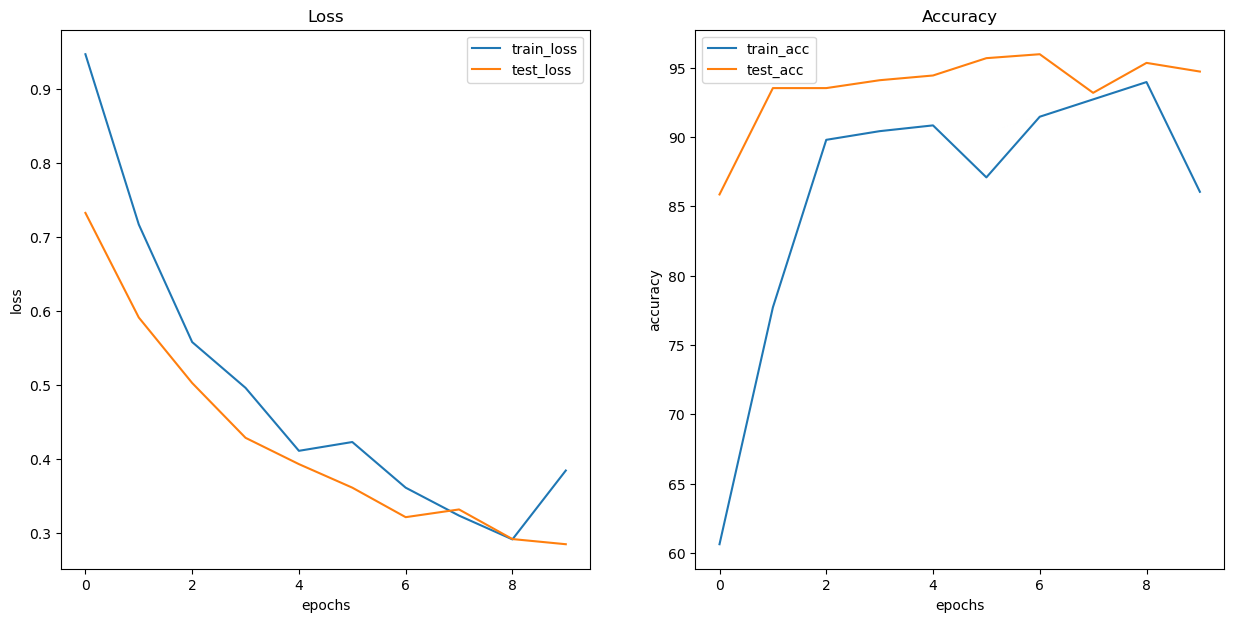

In [17]:
# plotting loss curves

import os
import sys

# Adding the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

try: 
    from helper_functions import plot_loss_curve
except ImportError:
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    helper_functions_path = os.path.join(parent_dir, "helper_functions.py")
    with open(helper_functions_path, "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/pratik-kadlak/Pytorch/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curve
    
plot_loss_curve(effnetb2_results)

In [18]:
# saving the model
from going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor.pth


In [19]:
# getting the size of the model 
# to that we can get the idea whether this model can be deployed on edge devices or not

from pathlib import Path
effnetb2_size = round(Path("models/pretrained_effnetb2_feature_extractor.pth").stat().st_size / (1024*1024), 2)
print(f"EffnetB2_Model_Size: {effnetb2_size :.2f} MB")

EffnetB2_Model_Size: 29.83 MB


In [20]:
# count no of parameter in EffnetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

# create a stat dictionary to compare the two models later
effnetb2_stat = {"test_loss": effnetb2_results["test_loss"][-1],
                 "test_acc": effnetb2_results["test_acc"][-1],
                 "num_parameters": effnetb2_total_params,
                 "model_size (MB)": effnetb2_size}

effnetb2_stat

{'test_loss': 0.2849543780088425,
 'test_acc': 94.7159090909091,
 'num_parameters': 7705221,
 'model_size (MB)': 29.83}

## Creating ViT Model

In [21]:
import torchvision
 
def create_vit_model():
    vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    
    # creating transform
    vit_transform = vit_weights.transforms()
    
    # create model
    vit = torchvision.models.vit_b_16(weights=vit_weights)
    
    # freeze all layers
    for param in vit.parameters():
        param.requires_grad = False
        
    # change the output layer
    vit.heads = nn.Linear(in_features=768,
                          out_features=len(class_names))
    
    return vit, vit_transform

In [22]:
vit, vit_transform = create_vit_model()

# printing summary
summary(vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential (layers)                                   [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]            [32, 197, 768]            (7,087,872)   

In [23]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transform,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit)

(15, 5)

In [24]:
# training the model
from going_modular import engine

# setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit, 
                                test_dataloader=test_dataloader_vit,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                epochs=10)

Epoch:0	Train_Loss:0.6178	Train_Acc:79.3750	Test_Loss:0.2303	Test_Acc:96.3068
Epoch:1	Train_Loss:0.2237	Train_Acc:94.3750	Test_Loss:0.1139	Test_Acc:98.1250
Epoch:2	Train_Loss:0.1589	Train_Acc:95.8333	Test_Loss:0.0895	Test_Acc:98.1250
Epoch:3	Train_Loss:0.1223	Train_Acc:96.4583	Test_Loss:0.0795	Test_Acc:98.1250
Epoch:4	Train_Loss:0.1050	Train_Acc:97.0833	Test_Loss:0.0717	Test_Acc:98.1250
Epoch:5	Train_Loss:0.0883	Train_Acc:97.2917	Test_Loss:0.0653	Test_Acc:98.7500
Epoch:6	Train_Loss:0.0765	Train_Acc:97.9167	Test_Loss:0.0618	Test_Acc:98.1250
Epoch:7	Train_Loss:0.0693	Train_Acc:98.5417	Test_Loss:0.0603	Test_Acc:98.1250
Epoch:8	Train_Loss:0.0665	Train_Acc:99.3750	Test_Loss:0.0585	Test_Acc:97.5000
Epoch:9	Train_Loss:0.0535	Train_Acc:99.1667	Test_Loss:0.0554	Test_Acc:96.8750


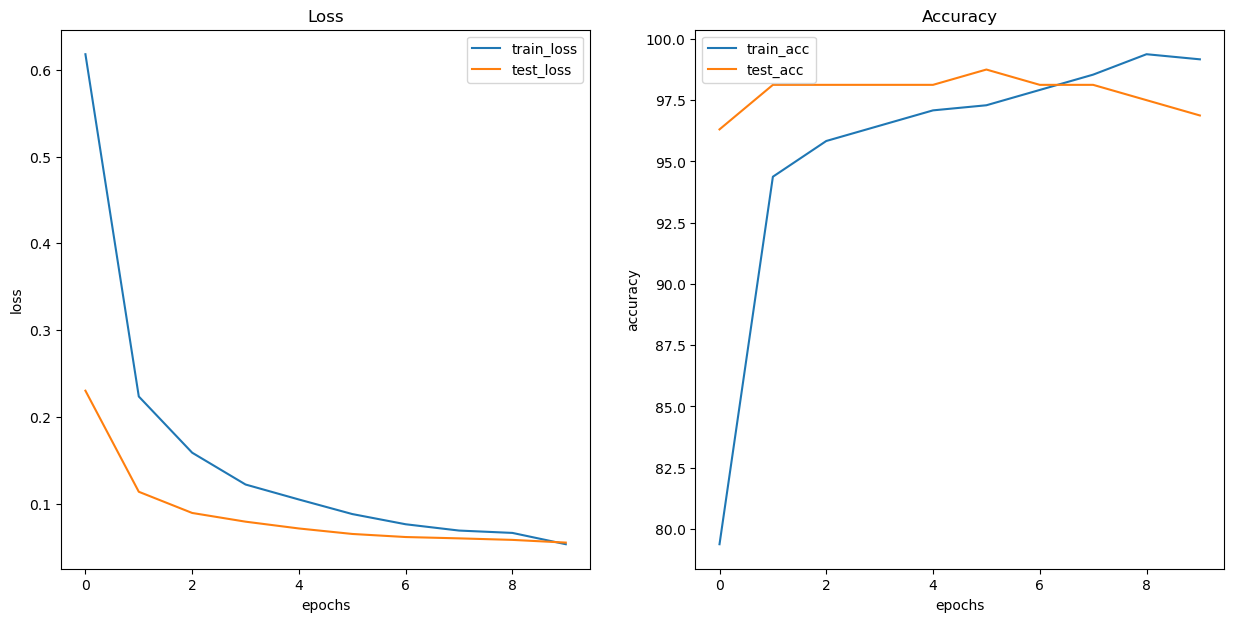

In [27]:
plot_loss_curve(vit_results)

In [28]:
# saving the model
from going_modular import utils
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor.pth


In [29]:
from pathlib import Path
vit_size = round(Path("models/pretrained_vit_feature_extractor.pth").stat().st_size / (1024*1024), 2)
print(f"EffnetB2_Model_Size: {vit_size :.2f} MB")

EffnetB2_Model_Size: 327.36 MB


In [30]:
# count no of parameter in EffnetB2
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

# create a stat dictionary to compare the two models later
vit_stat = {"test_loss": vit_results["test_loss"][-1],
                 "test_acc": vit_results["test_acc"][-1],
                 "num_parameters": vit_total_params,
                 "model_size (MB)": vit_size}

vit_stat

{'test_loss': 0.05539988027885556,
 'test_acc': 96.875,
 'num_parameters': 85800963,
 'model_size (MB)': 327.36}

__Creating a Func to Measure the time needed to predict__

In [54]:
import pathlib
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = device) -> List[Dict]:
    # create an empty list (can return a full list of all predictions later)
    pred_list = []
    
    # sending model to correct device
    model = model.to(device)
    
    # loop through the target input paths
    for path in tqdm(paths):
        # create an empty dict for each sample (predictions stats will go in this dict)
        pred_dict = {}
        
        # get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_names"] = class_name
        
        # now start the prediction timer
        start_time = timer()
        
        # open the image
        img = Image.open(path)
        
        # transform the image
        transformed_img = transform(img).unsqueeze(0).to(device) # adding a batch dim
        
        # make prediction
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim=1) # turn raw logits to probability dist
            pred_label = torch.argmax(pred_prob, dim=1) # turn the dist to label
            pred_class = class_names[pred_label.cpu()]
            
        # add pred_prob + pred_class to empty dict
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_class = pred_class
        
        # stop the timer
        end_time = timer()
        
        # calc total time
        pred_dict["time_for_pred"] = round(end_time-start_time, 4)
        
        # if out perdiciton is correct
        pred_dict["correct"] = class_name == pred_class
        
        # append the dict to the pred_list
        pred_list.append(pred_dict)
        
    return pred_list

In [55]:
# get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

#### making predictions with effnetb2

In [56]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transform,
                                          class_names=class_names,
                                          device="cpu") # because not everywhere we get GPU

effnetb2_test_pred_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('going_modular/data/test/steak/413497.jpg'),
  'class_names': 'steak',
  'pred_prob': 0.9106,
  'time_for_pred': 0.3166,
  'correct': True},
 {'image_path': PosixPath('going_modular/data/test/steak/2246332.jpg'),
  'class_names': 'steak',
  'pred_prob': 0.8992,
  'time_for_pred': 0.2827,
  'correct': True}]

In [57]:
# turn the dict to dataframe
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_names,pred_prob,time_for_pred,correct
0,going_modular/data/test/steak/413497.jpg,steak,0.9106,0.3166,True
1,going_modular/data/test/steak/2246332.jpg,steak,0.8992,0.2827,True
2,going_modular/data/test/steak/2475366.jpg,steak,0.8624,0.2732,True
3,going_modular/data/test/steak/1982192.jpg,steak,0.5593,0.2592,True
4,going_modular/data/test/steak/2353677.jpg,steak,0.5053,0.2685,True


In [58]:
# find the average time per prediction
effnetb2_avg_time = round(effnetb2_test_pred_df['time_for_pred'].mean(), 4)

# add avg time to effnetb2_stat
effnetb2_stat['avg_time'] = effnetb2_avg_time

print(f"Average Time Per Prediction: {effnetb2_avg_time}")

Average Time Per Prediction: 0.2692


#### making predictions with vit

In [59]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transform,
                                          class_names=class_names,
                                          device="cpu") # because not everywhere we get GPU

vit_test_pred_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('going_modular/data/test/steak/413497.jpg'),
  'class_names': 'steak',
  'pred_prob': 0.8445,
  'time_for_pred': 0.2076,
  'correct': True},
 {'image_path': PosixPath('going_modular/data/test/steak/2246332.jpg'),
  'class_names': 'steak',
  'pred_prob': 0.9984,
  'time_for_pred': 0.084,
  'correct': True}]

In [60]:
# turn the dict to dataframe
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_names,pred_prob,time_for_pred,correct
0,going_modular/data/test/steak/413497.jpg,steak,0.8445,0.2076,True
1,going_modular/data/test/steak/2246332.jpg,steak,0.9984,0.0840,True
2,going_modular/data/test/steak/2475366.jpg,steak,0.9974,0.0840,True
3,going_modular/data/test/steak/1982192.jpg,steak,0.9914,0.0842,True
4,going_modular/data/test/steak/2353677.jpg,steak,0.9581,0.0853,True


In [61]:
# find the average time per prediction
vit_avg_time = round(vit_test_pred_df['time_for_pred'].mean(), 4)

# add avg time to vit_stats
vit_stat["avg_time"] = vit_avg_time

print(f"Average Time Per Prediction: {vit_avg_time}")

Average Time Per Prediction: 0.0857


__Comparing Results__

In [62]:
# turn stat dicts into df
df = pd.DataFrame([effnetb2_stat, vit_stat])

# creating an extra col
df['model'] = ["EffNetB2", "ViT"]

df

,test_loss,test_acc,num_parameters,model_size (MB),avg_time,model
0,0.284954,94.715909,7705221,29.83,0.2692,EffNetB2
1,0.055400,96.875000,85800963,327.36,0.0857,ViT


In [63]:
# comparing ratios
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc['EffNetB2']),
             columns=['ViT To EffNetB2 ratios']).T

# num of parameters in ViT is 11 times higher than EffnetB2
# model size in ViT is also 11 times higher than EffnetB2

,test_loss,test_acc,num_parameters,model_size (MB),avg_time
ViT To EffNetB2 ratios,0.194417,1.022795,11.135432,10.974187,0.318351


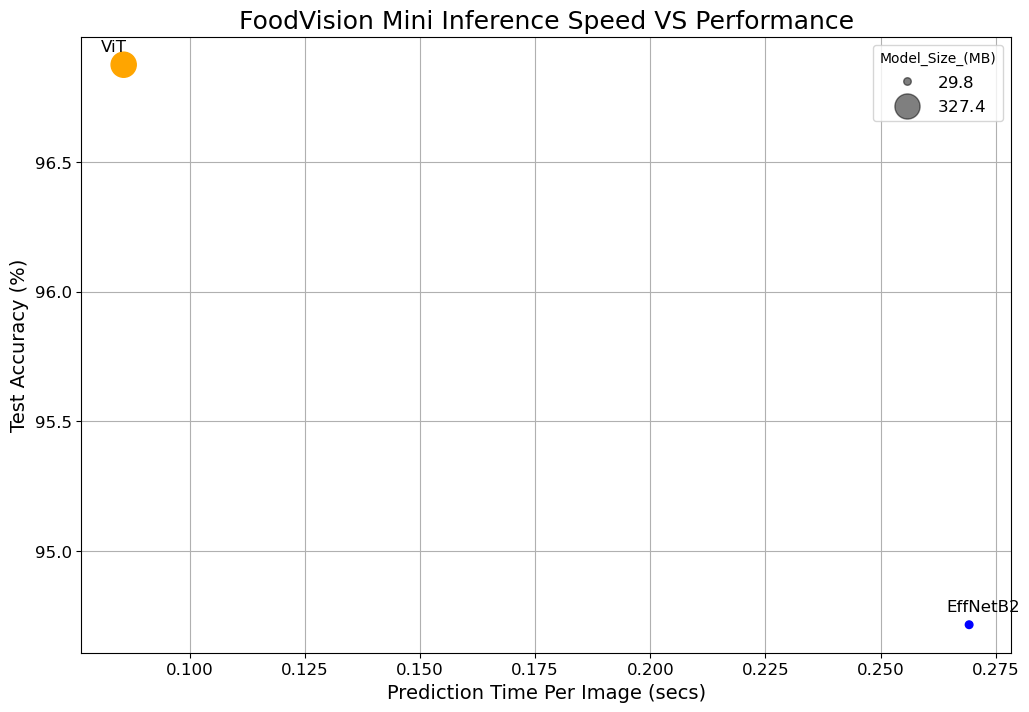

In [76]:
# visualizing the speed/performance ratio
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="avg_time",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# add titles and labels
ax.set_title("FoodVision Mini Inference Speed VS Performance", fontsize=18)
ax.set_xlabel("Prediction Time Per Image (secs)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# annotating the graph
for index, row in df.iterrows():
    ax.annotate(text=row['model'],
                xy=(row['avg_time']-.005, row['test_acc']+0.05),
                size=12)
    
# creating legend
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, labels, loc="upper right", title="Model_Size_(MB)", fontsize=12)